In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt


In [2]:
!pip install tensorflow==2.12.0


INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 26.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    

In [2]:
tf.__version__

'2.12.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/EdgeAI/Data/haarcascade_frontalface_default.xml')
age_gender_model = load_model('/content/drive/My Drive/EdgeAI/Results/2classes_final_age_gender_model.keras')
emotion_model = load_model('/content/drive/My Drive/EdgeAI/Results/TFN3_final_tf12_emotion_model.keras')

emotion_categories = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]


In [ ]:

def preprocess_image(image, size):
    """
    Preprocesses an image by resizing, converting to grayscale, normalizing, and reshaping it.
    """
    resized = cv2.resize(image, (size, size))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    normalized = gray.astype('float32') / 255.0
    return normalized.reshape(1, size, size, 1)



In [6]:

def predict_age_gender(face_img):
    """
    Makes predictions on age and gender based on the face image.
    """
    input_data = preprocess_image(face_img, 128)
    age_output, gender_output = age_gender_model.predict(input_data)

    gender = "Female" if gender_output[0][0] > 0.5 else "Male"
    gender_prob = max(gender_output[0][0], 1 - gender_output[0][0]) * 100

    age = "Elderly" if age_output[0][0] > 0.5 else "Adult"
    age_prob = max(age_output[0][0], 1 - age_output[0][0]) * 100

    return f"Gender: {gender} ({gender_prob:.2f}%)\nAge: {age} ({age_prob:.2f}%)"

def predict_emotion(face_img):
    """
    Predicts emotion based on the face image.
    """
    input_data = preprocess_image(face_img, 48)
    emotion_output = emotion_model.predict(input_data)
    max_index = np.argmax(emotion_output)
    emotion = emotion_categories[max_index]
    emotion_prob = emotion_output[0][max_index] * 100

    return f"Emotion: {emotion} ({emotion_prob:.2f}%)"

In [ ]:

def detect_and_predict(image):
    """
    Detects faces in an image and predicts age/gender and emotion for the largest face.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        print("No face detected")
        return

    largest_face = max(faces, key=lambda rect: rect[2] * rect[3])
    (x, y, w, h) = largest_face
    face_img = image[y:y+h, x:x+w]

    age_gender_prediction = predict_age_gender(face_img)
    emotion_prediction = predict_emotion(face_img)

    print(age_gender_prediction)
    print(emotion_prediction)

    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(image, age_gender_prediction + "\n" + emotion_prediction, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('off')  
    plt.show()

1/1 [==============================] - 0s 21ms/step
Gender: Male (100.00%)
Age: Adult (62.52%)
Emotion: Happy (99.96%)


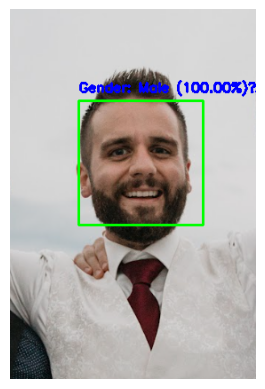

In [14]:
image = cv2.imread('/content/drive/My Drive/EdgeAI/Results/testpics/New/blizzyhappy.png')
detect_and_predict(image)